<a href="https://colab.research.google.com/github/Arush0113/ArushTensorflowRepo/blob/main/team02/Main/IITR_EEG_New_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/IITR EEG Intern/New Problem")

In [4]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
import numpy as np
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

In [5]:
# def read_data():
#     X_data = np.zeros((2, 38252, 14))
#     Y_data = np.zeros((2,))

#     sequence_length = 50
#     list_dataset = []

#     for index in range(X_data.shape[0]):
#         target = Y_data[index]     #taget shape -- (1,)
#         targets = np.repeat(target, X_data[index].shape[0])
#         dataset = tensorflow.keras.preprocessing.timeseries_dataset_from_array(X_data[index], targets, sequence_stride=50, sequence_length=50)
#         list_dataset.append(dataset)

#     dataset = list_dataset[0]
#     for i in list_dataset[1:]:
#         dataset = dataset.concatenate(i)
#     training_elements = int(len(dataset)*0.7) 

#     train_dataset = dataset.take(training_elements)
#     test_dataset = dataset.skip(training_elements) 

#     validation_elements = int(len(train_dataset)*0.2)
#     validation_dataset = train_dataset.take(validation_elements)
#     train_dataset = train_dataset.skip(validation_elements)
#     return train_dataset,validation_dataset,test_dataset

In [6]:
# train_dataset,validation_dataset,test_dataset = read_data()

In [7]:
import scipy.io
mat = scipy.io.loadmat('/content/drive/MyDrive/IITR EEG Intern/New Problem/data/subject_01/worry_visual_rejection_data.mat')

In [8]:
type(mat)

dict

In [9]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'hdr', 'label', 'time', 'trial', 'fsample', 'sampleinfo', 'trialinfo', 'cfg'])

In [10]:
import glob
import pandas as pd
import numpy as np
from scipy import io


def create_file(data_path:str,n_subjects:int, channels='all',band='alpha'):
    """
    A function to create the file by reading all the data.
    Args:
    ---------------
        data_path: string; path to read data from
        n_subjects: int; number of subjects 
    Returns:
        final_data: numpy array; contains concatenated data of all conditions
    ----------------
    """
    subject_list = ["subject_0" + str(i) for i in range(1,10)]
    subject_list.extend(["subject_" + str(i) for i in range(10,n_subjects+1)])
    del subject_list[3:5] # Removes subject 4 and 5
    # check if overwrite is True
    l_breath_data = []
    l_feet_data = []
    l_future_data = []
    l_worry_data = []
    print(f"Creating combined file for {channels} channels and {band} band\n")
    
    for dirs in glob.glob(data_path + str("/*")):
            if dirs.split('/')[-1] in subject_list: 
                for subject_files in glob.glob(dirs+str("/*")):
                    if subject_files.split("/")[-1] == f"breath_{channels}_{band}_data.mat":
                        content = io.loadmat(subject_files)[f'data_{channels}_{band}']
                        l_breath_data.append(content)
                        #print(f"here with {subject_files}")
                    elif subject_files.split("/")[-1] == f"feet_{channels}_{band}_data.mat":
                        content = io.loadmat(subject_files)[f'data_{channels}_{band}']
                        l_feet_data.append(content)
                    elif subject_files.split("/")[-1] == f"future_{channels}_{band}_data.mat":
                        content = io.loadmat(subject_files)[f'data_{channels}_{band}']
                        l_future_data.append(content)
                    elif subject_files.split("/")[-1] == f"worry_{channels}_{band}_data.mat":
                        content = io.loadmat(subject_files)[f'data_{channels}_{band}']
                        l_worry_data.append(content)
                    else:
                        continue

    breath_data = np.concatenate(l_breath_data,axis=0)
    feet_data = np.concatenate(l_feet_data,axis=0)
    future_data = np.concatenate(l_future_data,axis=0)
    worry_data = np.concatenate(l_worry_data,axis=0)
    
    # assert shapes and make sure they have four columns
#     breath_data.shape,feet_data.shape,future_data.shape,worry_data.shape
    
    breath_labels = np.zeros(breath_data.shape[0])
    feet_labels = np.ones(feet_data.shape[0])
    future_labels = np.full(future_data.shape[0],2)
    worry_labels = np.full(worry_data.shape[0],3)
    
    breath_data = np.c_[breath_data,breath_labels]
    feet_data = np.c_[feet_data,feet_labels]
    future_data = np.c_[future_data,future_labels]
    worry_data = np.c_[worry_data,worry_labels]
    
    final_data = np.concatenate((breath_data,feet_data,future_data,worry_data),axis=0)
    
    data_frame = pd.DataFrame(final_data)
    data_frame.to_csv(f"{data_path}/combined_{channels}_{band}.csv",index=None)

    return data_frame

In [11]:
import glob
import pandas as pd
import numpy as np
from scipy import io


def create_file_subject_wise(file_path:str,n_subjects:int,channels="all", band="alpha"):
    """
    A function to create the file by reading all the data.
    Args:
    ---------------
        data_path: string; path to read data from
        n_subjects: int; number of subjects 
    Returns:
        final_data: numpy array; contains concatenated data of all conditions
    ----------------
    """
#     subject_list_part1 = ["subject_0"+str(i) for i in range(1,10)]
#     subject_list_part2 = ["subject_" + str(i) for i in range(10,n_subjects+1)]
#     subject_list_final = subject_list_part1 + subject_list_part2

    l_breath_data = []
    l_feet_data = []
    l_future_data = []
    l_worry_data = []
    for subject_files in glob.glob(file_path+str("/*")):
        #print(f"here {subject_files}")
        if subject_files.split("/")[-1] == f"breath_{channels}_{band}_data.mat":
            content = io.loadmat(subject_files)[f'data_{channels}_{band}']
            l_breath_data.append(content)
            #print(f"here with {subject_files}")
        elif subject_files.split("/")[-1] == f"feet_{channels}_{band}_data.mat":
            content = io.loadmat(subject_files)[f'data_{channels}_{band}']
            l_feet_data.append(content)
        elif subject_files.split("/")[-1] == f"future_{channels}_{band}_data.mat":
            content = io.loadmat(subject_files)[f'data_{channels}_{band}']
            l_future_data.append(content)
        elif subject_files.split("/")[-1] == f"worry_{channels}_{band}_data.mat":
            content = io.loadmat(subject_files)[f'data_{channels}_{band}']
            l_worry_data.append(content)
        else:
            continue

    breath_data = np.concatenate(l_breath_data,axis=0)
    feet_data = np.concatenate(l_feet_data,axis=0)
    future_data = np.concatenate(l_future_data,axis=0)
    worry_data = np.concatenate(l_worry_data,axis=0)

    breath_labels = np.zeros(breath_data.shape[0])
    feet_labels = np.ones(feet_data.shape[0])
    future_labels = np.full(future_data.shape[0],2)
    worry_labels = np.full(worry_data.shape[0],3)

    breath_data = np.c_[breath_data,breath_labels]
    feet_data = np.c_[feet_data,feet_labels]
    future_data = np.c_[future_data,future_labels]
    worry_data = np.c_[worry_data,worry_labels]

    final_data = np.concatenate((breath_data,feet_data,future_data,worry_data),axis=0)

    data_frame = pd.DataFrame(final_data)
    data_frame.to_csv(file_path + str(f"/combined_{channels}_{band}.csv"),index=None)



    return data_frame

In [12]:
import os
from pathlib import Path
import glob
import pandas as pd
# from create_file import *
# from create_file_subject_wise import *

def read_data(file_path, data_path, n_subjects, channels="all", band="alpha",return_dataframe=False, overwrite=False):
    
    """
    A function to read the data from given file or create it.
    
    Args:
    ---------------
        file_path: string; check if the file exists or not
        data_path: string; path to read data from
        n_subjects: int; number of subjects 
        overwrite: boolean; whether to overwrite the existing data or not
    
    Returns:
        x: Feature columns of the data read
        y: labels of the data read
    ----------------
    """
    if not overwrite:
        # check if the file exists and set exists
        config = Path(file_path)
        try:
            absolute_path = config.resolve()
            data = pd.read_csv(absolute_path)
            print(f"File found {file_path}")
        except FileNotFoundError as e:         
            print(e)
            print("\n====================================\n")
            print(f"Reading the data and creating the file at {data_path}")
            data = create_file(data_path,n_subjects,channels=channels, band=band)
    else:
        data = create_file(data_path,n_subjects,channels=channels, band=band)
   
    data_np = np.array(data)
    
    x = data_np[:,0:data_np.shape[-1]-1]
    y = data_np[:,data_np.shape[-1]-1]

    if return_dataframe==False:
        return x,y
    else:
        return x,y,data


def read_data_subject_wise(file_path, data_path, n_subjects,channels="all", band="alpha",return_dataframe=False, overwrite=False):
    
    """
    A function to read the data from given file or create it.
    
    Args:
    ---------------
        file_path: string; check if the file exists or not
        data_path: string; path to read data from
        n_subjects: int; number of subjects 
        overwrite: boolean; whether to overwrite the existing data or not
    
    Returns:
        x: Feature columns of the data read
        y: labels of the data read
    ----------------
    """
    if not overwrite:
        # check if the file exists and set exists
        config = Path(file_path)
        try:
            absolute_path = config.resolve()
            data = pd.read_csv(absolute_path)
            print(f"File found {file_path}")
        except FileNotFoundError as e:         
            print(e)
            print("\n====================================\n")
            print(f"Reading the data and creating the file at {data_path}")
            data = create_file_subject_wise(data_path,n_subjects,channels=channels, band=band)
    else:
        data = create_file_subject_wise(data_path,n_subjects,channels=channels, band=band)
   
    #print(f"Data read looks like {data.head()} and the shape of data is {data.shape}")
    data_np = np.array(data)
    #print(data_np.shape)
    x = data_np[:,0:data_np.shape[1]-1]
    y = data_np[:,data_np.shape[1]-1]
    
    if return_dataframe==False:
        return x,y
    else:
        return x,y,data

In [13]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 3.8 MB/s 


In [14]:
import kerastuner as kt
from tensorboard.plugins.hparams import api as hp
from kerastuner import HyperModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from kerastuner.tuners import Hyperband
from tensorflow.keras.optimizers import Adam

class Model(HyperModel):
    def __init__(self, classifier):
        self.classifier_name = classifier.name
        self.act_values = classifier.act_values
        self.LRs = classifier.LRs
        self.min_value = classifier.min_value
        self.max_value = classifier.max_value
        self.step = classifier.step

    def build(self, hp):
        model = Sequential()
        model.add(InputLayer(input_shape = (50, 14)))   
        model.add(Dense(hp.Int(name = 'start_neurons', min_value = self.min_value, max_value = self.max_value, step = self.step),                               kernel_regularizer='l2', activation = hp.Choice(name = 'activation', values = list(self.act_values), ordered = False)))
        model.add(Dense(1, kernel_regularizer='l2',activation = 'sigmoid'))
        model.compile(optimizer = Adam( hp.Choice('learning_rate',
                          values=list(self.LRs))),
                        loss = 'binary_crossentropy',
                        metrics = ['accuracy'])
        return model
    
    def __str__(self):
        return f"The {self.classifier_name} is runnning with the configuration as defined in conf/classifier/{self.classifier_name}.yaml"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [15]:
# Adding path to import files from src folder
import sys
# insert at 1, 0 is the script path (or '' in REPL)
# 1 in the insert function ensures that it’s loaded with higher priority and avoids some naming conflicts
sys.path.insert(1, '../src')

import glob 
import os
import numpy as np
import sklearn
import logging
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# from utils import *

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

%load_ext autoreload
%autoreload 

In [16]:
n_subjects = 21
data_path = "/content/drive/MyDrive/IITR EEG Intern/New Problem/data/"
channels = "occipital"
band= "alpha"
file_path = f"/content/drive/MyDrive/IITR EEG Intern/New Problem/data/combined_{channels}_{band}.csv"

In [17]:
# /content/drive/MyDrive/IITR EEG Intern/New Problem/data/subject_01/worry_visual_rejection_data.mat

In [18]:
x, y  = read_data(file_path, data_path, n_subjects, channels=channels, band=band, overwrite=False)

File found /content/drive/MyDrive/IITR EEG Intern/New Problem/data/combined_occipital_alpha.csv


In [19]:
x.shape

(17947, 4)

In [20]:
y.shape

(17947,)

In [21]:
type(x)

numpy.ndarray

In [22]:
y

array([0., 0., 0., ..., 3., 3., 3.])

In [23]:
#printing all unique values in y
list(set(y))

[0.0, 1.0, 2.0, 3.0]

In [24]:
num_classes = 4
y = tf.keras.utils.to_categorical(y, num_classes)
y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [25]:
x_train,x_temp,y_train,y_temp = train_test_split(x,y,test_size=0.30,shuffle=True,stratify=y,random_state=42)
x_val,x_test,y_val,y_test = train_test_split(x_temp,y_temp,test_size=0.50,shuffle=True,stratify=y_temp,random_state=42)

In [26]:
# list(set(y))

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
#Creating model architecture

num_classes = 4

inp_shape = (4,)
ip = tf.keras.Input(shape = inp_shape)
dense1 = tf.keras.layers.Dense(units = 32, activation = 'relu', kernel_initializer = 'random_normal')(ip)
dense2 = tf.keras.layers.Dense(units = 16, activation = 'relu', kernel_initializer = 'random_normal')(dense1)
drop2 = tf.keras.layers.Dropout(.3)(dense2)
out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(drop2)

mlp = tf.keras.Model(inputs = ip, outputs = out)
mlp.summary()
# inp_shape = (None, )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 756
Trainable params: 756
Non-trainable params: 0
_________________________________________________________________


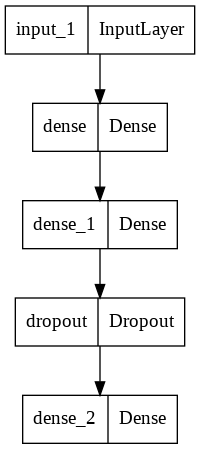

In [29]:
tf.keras.utils.plot_model(mlp)

In [30]:
# Compiling the model
mlp_earlystop = EarlyStopping(patience = 20, min_delta = 0.001, monitor = 'val_acc')

path = 'mlp_checkpoint/checkpoint_{epoch:02d}';
mlp_checkpoint = ModelCheckpoint(filepath = path,
                            verbose = 1,
                            monitor = 'val_acc',
                            save_freq = 'epoch',
                            save_best_only = True,
                            save_weights_only = True)

mlp.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [31]:
mlp_history = mlp.fit(x_train, y_train,
                      validation_data = (x_temp, y_temp),
                      epochs = 100,
                      batch_size = 32,
                      shuffle = True,
                      callbacks = [
                                  #  mlp_earlystop,
                                   mlp_checkpoint,
                                   ],
                     ) #Fitting the model

Epoch 1/100
382/393 [============================>.] - ETA: 0s - loss: 1.3914 - acc: 0.2505
Epoch 00001: val_acc improved from -inf to 0.25571, saving model to mlp_checkpoint/checkpoint_01
393/393 [==============================] - 5s 6ms/step - loss: 1.3913 - acc: 0.2501 - val_loss: 1.3861 - val_acc: 0.2557
Epoch 2/100
393/393 [==============================] - ETA: 0s - loss: 1.3864 - acc: 0.2532
Epoch 00002: val_acc improved from 0.25571 to 0.25812, saving model to mlp_checkpoint/checkpoint_02
393/393 [==============================] - 2s 6ms/step - loss: 1.3864 - acc: 0.2532 - val_loss: 1.3860 - val_acc: 0.2581
Epoch 3/100
382/393 [============================>.] - ETA: 0s - loss: 1.3862 - acc: 0.2528
Epoch 00003: val_acc did not improve from 0.25812
393/393 [==============================] - 2s 5ms/step - loss: 1.3861 - acc: 0.2533 - val_loss: 1.3861 - val_acc: 0.2565
Epoch 4/100
389/393 [============================>.] - ETA: 0s - loss: 1.3863 - acc: 0.2553
Epoch 00004: val_acc d

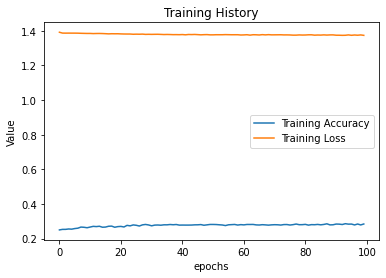

Initial training accuracy is:  0.2501194179058075
Final training accuracy is:  0.28434962034225464
Initial training loss is:  1.3912708759307861
Final training loss is:  1.3733985424041748


In [32]:
#Plotting model history
plt.plot(mlp_history.history['acc'])
plt.plot(mlp_history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial training accuracy is: ", mlp_history.history['acc'][0])
print("Final training accuracy is: ", mlp_history.history['acc'][-1])

print("Initial training loss is: ", mlp_history.history['loss'][0])
print("Final training loss is: ", mlp_history.history['loss'][-1])

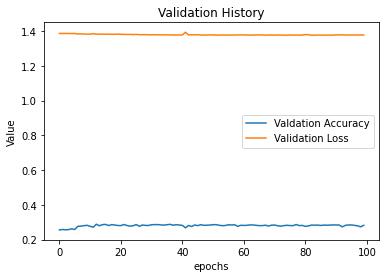

Initial validation accuracy is:  0.25571030378341675
Final validation accuracy is:  0.2822655439376831
Initial validation loss is:  1.3860995769500732
Final validation loss is:  1.376991629600525


In [33]:
#Plotting model history
plt.plot(mlp_history.history['val_acc'])
plt.plot(mlp_history.history['val_loss'])
plt.legend(['Valdation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial validation accuracy is: ", mlp_history.history['val_acc'][0])
print("Final validation accuracy is: ", mlp_history.history['val_acc'][-1])

print("Initial validation loss is: ", mlp_history.history['val_loss'][0])
print("Final validation loss is: ", mlp_history.history['val_loss'][-1])

## Feature Extract Model

In [47]:
x

array([[[  9.02371982],
        [  3.74238   ],
        [ 12.72616877],
        [  9.22876301]],

       [[ 11.08615172],
        [  7.2494996 ],
        [ 21.52443057],
        [ 14.28126423]],

       [[ 13.1138586 ],
        [  7.29578872],
        [ 13.23728385],
        [  6.3918014 ]],

       ...,

       [[ 76.35266874],
        [104.22933575],
        [ 49.61709483],
        [ 66.43769832]],

       [[ 73.28219835],
        [ 67.17111916],
        [ 14.156779  ],
        [ 62.38203396]],

       [[ 53.31600865],
        [ 39.76976057],
        [  8.86479039],
        [  8.18965969]]])

In [35]:
x = np.expand_dims(x, -1)

In [48]:
x.shape

(17947, 4, 1)

In [37]:
dims_lstm_1 = 4
dims_lstm_2 = 1

In [38]:
print(x.shape)
print(y.shape)

(17947, 4, 1)
(17947, 4)


In [49]:
x_train,x_temp,y_train,y_temp = train_test_split(x,y,test_size=0.30)

In [60]:
inp_shape = (dims_lstm_1, dims_lstm_2)
ip = tf.keras.Input(shape = inp_shape)
conv1 = tf.keras.layers.Conv1D(16, 3, activation = 'relu')(ip)
conv1 = tf.keras.layers.ZeroPadding1D(padding=1)(conv1)
rel1 = tf.keras.layers.ReLU()(conv1)
# maxpool1 = tf.keras.layers.MaxPooling1D()(conv1)
skip1 = rel1
conv2 = tf.keras.layers.Conv1D(16, 3, activation = 'relu')(rel1)
conv2 = tf.keras.layers.ZeroPadding1D(padding=1)(conv2)
rel2 = tf.keras.layers.ReLU()(conv2)
# maxpool2 = tf.keras.layers.MaxPooling1D()(conv2)
# maxpool2 = tf.keras.layers.ZeroPadding1D(padding=(44,43))(maxpool2)
skip2 = rel2
conv3 = tf.keras.layers.Conv1D(16, 3, activation = 'relu')(rel2)
conv3 = tf.keras.layers.ZeroPadding1D(padding=1)(conv3)
rel3 = tf.keras.layers.ReLU()(conv3)
# conv4 = tf.keras.layers.Conv1D(32,)(conv3)
# conv4 = tf.keras.layers.ZeroPadding1D(padding=1)(conv4)
# conv5 = tf.keras.layers.Conv1D(32,)(conv4)
# conv5 = tf.keras.layers.ZeroPadding1D(padding=1)(conv5)
# maxpool5 = tf.keras.layers.MaxPooling1D()(conv5)
# maxpool5 = tf.keras.layers.ZeroPadding1D(padding=(44, 43))(maxpool5)
addlayer1 = tf.keras.layers.Add()([skip1, skip2, rel3])

# lstm = tf.keras.layers.LSTM(16, return_sequences=True)(ip)
flatten = tf.keras.layers.Flatten()(addlayer1)
dense1 = tf.keras.layers.Dense(units = 32, kernel_initializer = 'random_normal')(flatten)
# leakyRelu = tf.keras.layers.LeakyReLU()(dense1)
# drop1 = tf.keras.layers.Dropout(.4)(dense1)
dense2 = tf.keras.layers.Dense(units = 16, kernel_initializer = 'random_normal')(dense1)
# leakyRelu2 = tf.keras.layers.LeakyReLU()(dense2)
drop2 = tf.keras.layers.Dropout(.3)(dense2)
out = tf.keras.layers.Dense(num_classes, activation = 'softmax')(drop2)

ftExtract = tf.keras.Model(inputs = ip, outputs = out)
ftExtract.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 4, 1)]       0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 2, 16)        64          ['input_6[0][0]']                
                                                                                                  
 zero_padding1d_12 (ZeroPadding  (None, 4, 16)       0           ['conv1d_12[0][0]']              
 1D)                                                                                              
                                                                                                  
 re_lu_10 (ReLU)                (None, 4, 16)        0           ['zero_padding1d_12[0][0]']

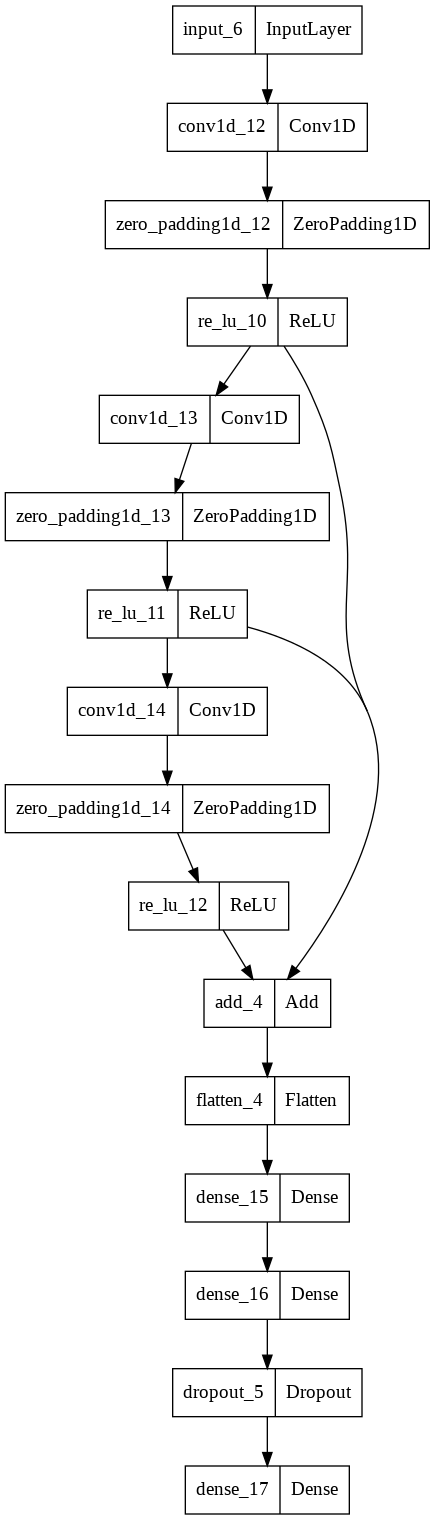

In [61]:
tf.keras.utils.plot_model(ftExtract)

In [62]:
# Compiling the model
fte_earlystop = EarlyStopping(patience = 15, min_delta = 0.001, monitor = 'val_acc')

path = 'fte_checkpoint/checkpoint_{epoch:02d}';
fte_checkpoint = ModelCheckpoint(filepath = path,
                            verbose = 1,
                            monitor = 'val_acc',
                            save_freq = 'epoch',
                            save_best_only = True,
                            save_weights_only = True)

ftExtract.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [63]:
ftExtract_history = ftExtract.fit(x_train, y_train,
                      validation_data = (x_temp, y_temp),
#                         steps_per_epoch= 449,
                        batch_size = 32,
                        epochs = 50,
                        callbacks = [fte_checkpoint],
                    ) #Fitting the model

Epoch 1/50
393/393 [==============================] - ETA: 0s - loss: 1.4088 - acc: 0.2609
Epoch 00001: val_acc improved from -inf to 0.27447, saving model to fte_checkpoint/checkpoint_01
393/393 [==============================] - 4s 9ms/step - loss: 1.4088 - acc: 0.2609 - val_loss: 1.3871 - val_acc: 0.2745
Epoch 2/50
392/393 [============================>.] - ETA: 0s - loss: 1.3902 - acc: 0.2674
Epoch 00002: val_acc improved from 0.27447 to 0.27762, saving model to fte_checkpoint/checkpoint_02
393/393 [==============================] - 3s 8ms/step - loss: 1.3902 - acc: 0.2672 - val_loss: 1.3870 - val_acc: 0.2776
Epoch 3/50
393/393 [==============================] - ETA: 0s - loss: 1.3864 - acc: 0.2715
Epoch 00003: val_acc did not improve from 0.27762
393/393 [==============================] - 3s 7ms/step - loss: 1.3864 - acc: 0.2715 - val_loss: 1.3887 - val_acc: 0.2628
Epoch 4/50
388/393 [============================>.] - ETA: 0s - loss: 1.3850 - acc: 0.2693
Epoch 00004: val_acc impro

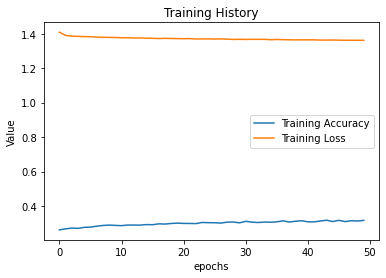

Initial training accuracy with preprocessing is:  0.26086610555648804
Final training accuracy with preprocessing is:  0.3164305090904236
Initial training loss with preprocessing is:  1.408787727355957
Final training loss with preprocessing is:  1.3616915941238403


In [64]:
#Plotting model history
plt.plot(ftExtract_history.history['acc'])
plt.plot(ftExtract_history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial training accuracy with preprocessing is: ", ftExtract_history.history['acc'][0])
print("Final training accuracy with preprocessing is: ", ftExtract_history.history['acc'][-1])

print("Initial training loss with preprocessing is: ", ftExtract_history.history['loss'][0])
print("Final training loss with preprocessing is: ", ftExtract_history.history['loss'][-1])

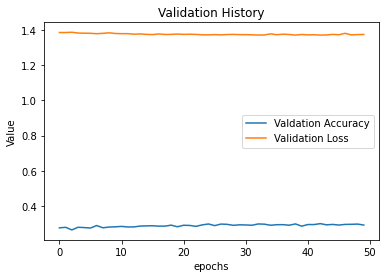

Initial Validation accuracy with preprocessing is:  0.2744660973548889
Final Validation accuracy with preprocessing is:  0.29043638706207275
Initial Validation loss with preprocessing is:  1.3871111869812012
Final Validation loss with preprocessing is:  1.3759102821350098


In [65]:
#Plotting model history
plt.plot(ftExtract_history.history['val_acc'])
plt.plot(ftExtract_history.history['val_loss'])
plt.legend(['Valdation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial Validation accuracy with preprocessing is: ", ftExtract_history.history['val_acc'][0])
print("Final Validation accuracy with preprocessing is: ", ftExtract_history.history['val_acc'][-1])

print("Initial Validation loss with preprocessing is: ", ftExtract_history.history['val_loss'][0])
print("Final Validation loss with preprocessing is: ", ftExtract_history.history['val_loss'][-1])